<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/py_torch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorhc workflow

Let's explore an example PyTorch end-to-end workflow




In [1]:
import torch
from torch import nn # nn contains all of Pytorch's building blocks of neural networks
import matplotlib.pyplot as plt

In [2]:
# Check Pytorch version
torch.__version__

'2.3.0+cu121'

## 1. Data (preparing and loading)


In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

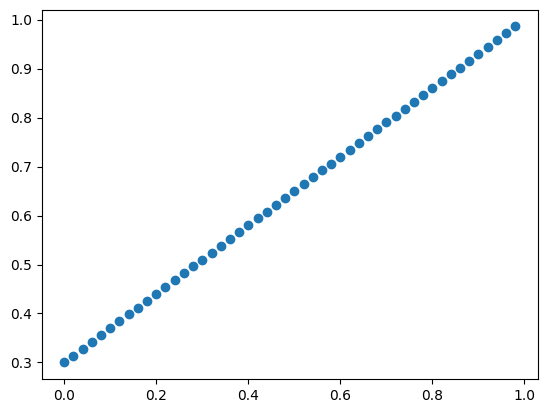

In [4]:
plt.scatter(X, y)
plt.show()

### Splitting dta into training and test sets

In [8]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [9]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [11]:
def plot_prediction(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

    # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
  if predictions is not None:
        # Plot the predictions if they exist
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})
  plt.show()


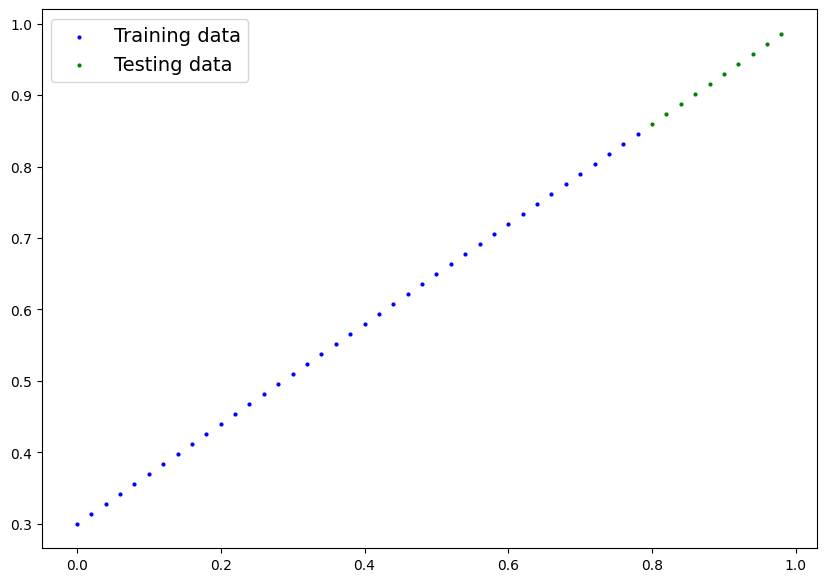

In [12]:
plot_prediction()

## 2. Build model

In [26]:
# Cerate a linear regression model class

class LinearRegresionModel(nn.Module): # <- almost everything in Pytorch inherents from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(
            1, # <- start with a random weight and try to adjuts it to the ideal weight
            requires_grad=True, # <- can this parameter be updated via gradient descent?
            dtype=torch.float, # PyTorch loves the dattype torch.float32
            ),
        )

        self.bias = nn.Parameter(torch.randn(1,
            requires_grad=True,
            dtype=torch.float,
            ),
        )

    # Forward method to define teh computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data1
        return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

### Checking the content of our PyTorch model

In [28]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegresionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [29]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediciton using `torch.inference_mode()`

In [34]:
# Make predicitions with mode

with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

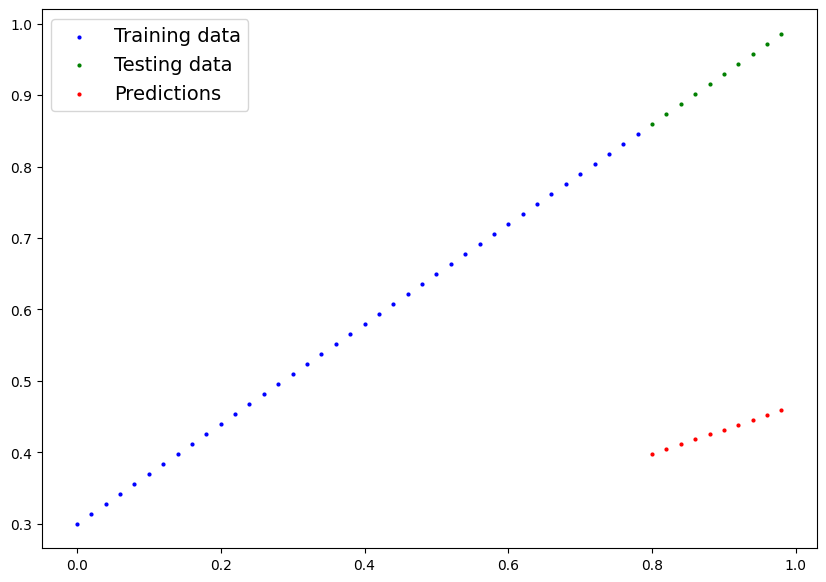

In [35]:
plot_prediction(predictions=y_preds)

In [36]:
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

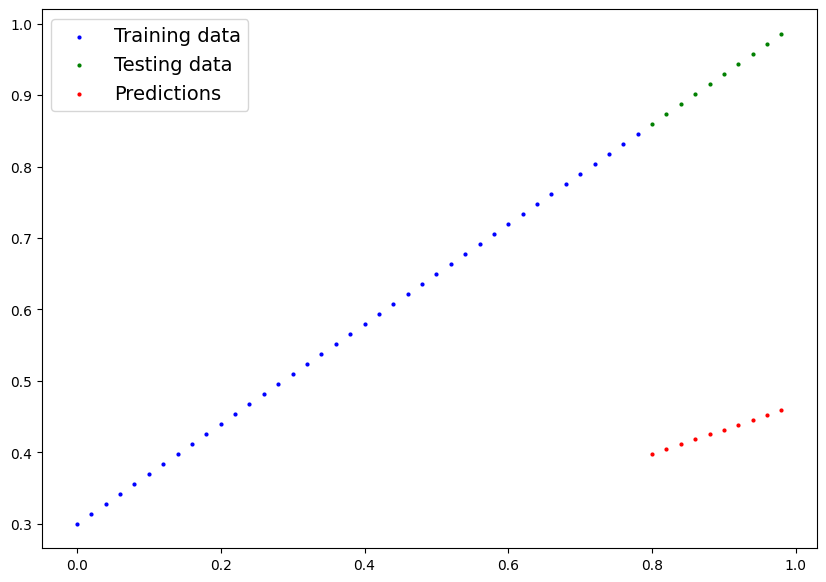

In [37]:
plot_prediction(predictions=y_preds)

## 3. Train model

In [39]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # lr= learning rate

### Building a trainig loop (and testing loop) in PyTorch

In [47]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  model_0.train() # train mode in PyTorch

  # Forward pass
  y_pred = model_0(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Perform backpropagation on the loss with respect to the parameters of the mdoel
  loss.backward()

  # Step teh optimizer (perform gradient descent)
  optimizer.step() # by default hoe the optimizer changes will acumulate through the loop soo... we have to zero them above in step 3

  # Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation

  with torch.inference_mode():
     # 1. Do the forward pass
     test_pred = model_0(X_test)

     # 2. Calculate the loss
     test_loss = loss_fn(test_pred, y_test.unsqueeze(dim=1))

     # Print out what's happening
     if epoch % 10 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

       print(model_0.state_dict())

  print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.19767 | Test loss: 0.34636
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 0 | Loss: 0.19767 | Test loss: 0.34636
Epoch: 1 | Loss: 0.18615 | Test loss: 0.33288
Epoch: 2 | Loss: 0.17463 | Test loss: 0.31941
Epoch: 3 | Loss: 0.16311 | Test loss: 0.30594
Epoch: 4 | Loss: 0.15159 | Test loss: 0.29247
Epoch: 5 | Loss: 0.14007 | Test loss: 0.27900
Epoch: 6 | Loss: 0.12855 | Test loss: 0.26553
Epoch: 7 | Loss: 0.11702 | Test loss: 0.25206
Epoch: 8 | Loss: 0.10609 | Test loss: 0.23960
Epoch: 9 | Loss: 0.09681 | Test loss: 0.22818
Epoch: 10 | Loss: 0.08909 | Test loss: 0.21730
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 10 | Loss: 0.08909 | Test loss: 0.21730
Epoch: 11 | Loss: 0.08228 | Test loss: 0.20696
Epoch: 12 | Loss: 0.07639 | Test loss: 0.19774
Epoch: 13 | Loss: 0.07160 | Test loss: 0.18909
Epoch: 14 | Loss: 0.06748 | Test loss: 0.18102
Epoch: 15 | Loss: 0.06395 | Test loss: 0.17353
Epoch: 16 | Loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [48]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5954])), ('bias', tensor([0.3438]))])

In [49]:
weight, bias

(0.7, 0.3)

In [50]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8201],
        [0.8320],
        [0.8439],
        [0.8558],
        [0.8678],
        [0.8797],
        [0.8916],
        [0.9035],
        [0.9154],
        [0.9273]])

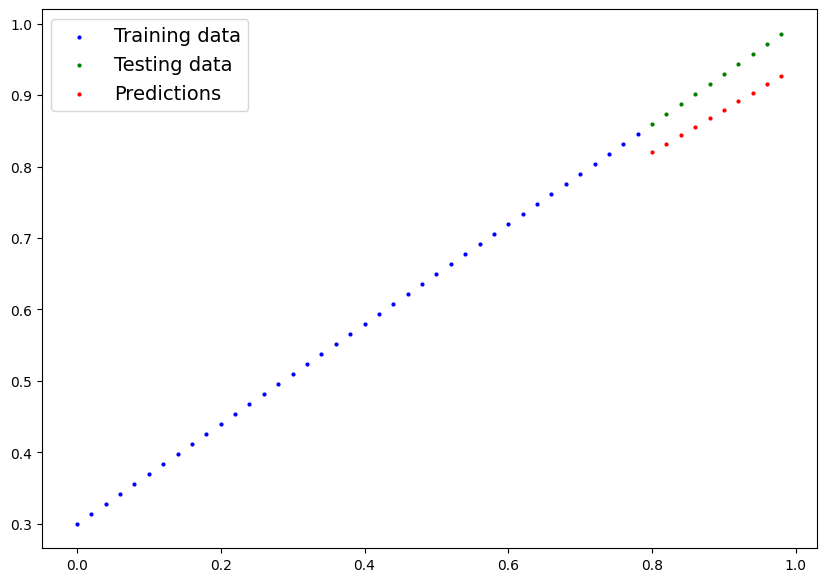

In [51]:
plot_prediction(predictions=y_preds)